## Recommender systems
A lot of recommender systems are built on matrix factorization models, where the partially observed matrix of user/item interactions is approximated by a product of matrices encoding latent characteristics of users and items. They can be corrected by user and item bias terms, and modified by activation functions that map to the data type of the observed interactions (e.g. binary kudos on Strava activities, counts of visits of a YouTube channel, ratings on Tripadvisor, or time spent watching a TikTok video before swiping up).

In machine learning, these matrix factorizations are often implemented as embeddings into latent spaces followed by scalar products of the user latent vectors by the item latent vectors, and the model is fit to historical data with a gradient descent algorithm. A [Keras tutorial on collaborative filtering](https://keras.io/examples/structured_data/collaborative_filtering_movielens/) describes the methodology with the Movielens dataset.

While the resulting model only provides point estimates of future interactions between users and items, a Bayesian treatment of the problem would add an approximation of the uncertainty of these estimates. Formally, we could express the same model with priors on the vector embeddings in a probabilistic programming library and sample the posteriors with an MCMC algorithm, but computing the likelihood of past interactions can be impractical for very large datasets. Moreover, due to the invariance of the model under permutations of the embedding dimensions, MCMC sampling of the multimodal posterior would be a nightmare. On the other hand, minimizing the Kullback-Leibler divergence $D_{KL}\left(Q(Z) \Vert P(Z\vert X)\right)$ between a surrogate posterior and the true posterior distribution through variational inference produces a mode-seeking behavior (see for instance these [lecture notes](https://www.fil.ion.ucl.ac.uk/~wpenny/talks/inference.pdf)), a bit like gradient descent in "classical" machine learning finds a local minimum.

In this blog post, we will be exploring how to implement a model inspired by Gopalan, Hofman and Blei ([Scalable Recommendation with Poisson Factorization](https://arxiv.org/abs/1311.1704)) with [TensorFLow Probability](https://www.tensorflow.org/probability).

## Bayesian models and variational inference
As a reminder, minimizing the (intractable) Kullback-Leibler divergence $D_{KL}\left(Q(Z) \Vert P(Z\vert X)\right)$ between the variational distribution $Q(Z)$ and the true posterior $P(Z\vert X)$ is equivalent to maximizing the (computable) [evidence lower bound](https://en.wikipedia.org/wiki/Evidence_lower_bound)

$$
\mathrm{ELBO} = \mathbb{E}_Q\left[ \log P(X \vert Z) \right] - D_{KL}(Q(Z) \Vert P(Z)),
$$

where the first term is the expectation under the surrogate distribution of the likelihood function of the model and the second term the negative Kullback-Leibler divergence between the surrogate distribution and the prior distribution of the model parameters.

In the mean field approximation, where we assume that the variational distribution $Q$ factorizes over the latent variables, we can implement variational inference with probabilistic layers from the `tfp.layers` module, which will automatically keep track of the variational parameters during training. These layers are conveniently combined in a Keras model, where the last layer is typically a distribution layer corresponding to the observed data $X$, and from which which we can use the `log_prob` method to compute the log-likelihood of the model. In their forward mode, the probabilistic layers draw samples from the surrogate distribution $Q$ they implement that we can use to compute Monte-Carlo estimates of $\mathbb{E}_Q\left[ \log P(X \vert Z) \right]$, the first part of the ELBO function.

The second part, $D_{KL}(Q(Z) \Vert P(Z))$, can be implemented either through an activity regularizer, `activity_regularizer = tfpl.KLDivergenceRegularizer(prior_distribution)`, or through a custom loss term added in the call method of the layer. The former is suitable for global parameters of the model that are shared by all training examples, and the latter is required for latent variables associated to specific training examples.

We will wrap up these initial theoretical considerations with a couple of observations that are important for a good implementation of these methods. The first is that Keras models are trained through minimization of a loss function, so instead of maximizing the ELBO, we will be minimizing the negative ELBO. Concretely, the loss function passed to the `model.compile` method will be the negative log-likelihood, and $D_{KL}(Q(Z) \Vert P(Z))$ will be added to the loss rather than subtracted from it. The second is that Keras model training routines evaluate the loss function as a sum over the training examples. While this is straightforward for the likelihood part of the loss when observations are assumed to be conditionally independent,

$$
- \log P(X \vert Z) = - \sum_i  \log P(X_i \vert Z),
$$

extra care needs to be taken for the Kullback-Leibler term

$$
D_{KL}(Q(Z) \Vert P(Z)) = \mathbb{E}_Q\left[ \log Q(Z) - \log P(Z))\right],
$$

which has to be expressed as a sum over the training examples like the log-likelihood. In practice, this can often be achieved through a weighted sum. For instance, if we have only parameters that are shared by all training examples, we can apply a $1/N$ weight, where $N$ is the number of data points $X_i$,

$$
- \mathrm{ELBO} =  \mathbb{E}_Q\left[ \sum_i \left( - \log P(X_i \vert Z) + \frac{1}{N}( \log Q(Z) - \log P(Z))\right) \right].
$$

For parameters linked to only subsets of the data points, or even individual data points (we often speak of latent variables), a bit of algebra might be needed to find the proper weights.

Constant weights can be specified as optional parameters of methods like `tfpl.KLDivergenceRegularizer`, but non-uniform weights have to be coded in the `add_loss` method of the Keras model, which is the reason why this approach is required as mentioned earlier.

## Probabilistic embeddings
While a standard embedding maps discrete values to vectors in a latent space, a probabilistic embedding specifies a probability distribution over the latent space. It can be constructed as a sequence of a parameter layer, that contains the variational distribution parameters, and a TensorFlow Probability distribution layer that encapsulates the sample method and the prior distribution for the KL term. The parameter layer can be expressed as a standard embedding into a space of dimension $n_{params} \times D$, where $D$ is the dimension of the original latent space, and $n_{params}$ the number of variational parameters of the corresponding component of the variational distribution $Q$.

In [1]:
#| include: false
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt

import tensorflow_probability as tfp
tfd = tfp.distributions
tdb = tfp.bijectors
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers

In [2]:
#| include: false

#the following two cells are recycled from the keras tutorial

# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = tfk.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)

In [3]:
#| include: false

#process the data
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)

In [4]:
#| include: false

#split the training and validation data
df_train = df.sample(frac=1, random_state=42)
# Assuming training on 90% of the data and validating on 10%
train_indices = int(0.9 * df.shape[0])

df_train, df_val = df_train.iloc[:train_indices], df_train.iloc[train_indices:]

def get_user_movie_ratings(df):
    x = df[["user", "movie"]].values
    # Rescale the ratings to integer counts between 0 and 9 and cast as float for
    # compatibility with the log_prob method of the tfd.Poisson distribution
    y = (2*df['rating']-1).astype('float').values
    return x, y

x_train, y_train = get_user_movie_ratings(df_train)
x_val, y_val = get_user_movie_ratings(df_val)

A [custom Keras layer](https://keras.io/guides/making_new_layers_and_models_via_subclassing/) wraps the construction of a probabilistic embedding, with its `__init__` method receiving the hyperparameters. In the following code example, we picked Gamma distributions for both the priors and the variational distributions. Note how the KL term is added to the loss with `self.add_loss` and weighted by `latent_kl_weights` passed as an argument to the call method of the custom Keras layer. It allows us to specify a unique weight for each training example from `inputs`.

In [5]:
class GammaEmbedding(tfkl.Layer):
    def __init__(self, num_classes, embedding_size,
                 embedding_concentration, embedding_rate,
                 **kwargs):
        super(GammaEmbedding, self).__init__(**kwargs)
        
        self.embedding_parameters = tfkl.Embedding(
            num_classes,
            2 * embedding_size,
            embeddings_initializer="he_normal"
        )
        
        self.embedding_distribution = tfpl.DistributionLambda(
            lambda x: tfd.Independent(
                tfd.Gamma(tf.math.exp(x[:, :embedding_size]),
                          rate=tf.math.exp(x[:, embedding_size:])),
                reinterpreted_batch_ndims=1)
        )
        
        self.embedding_prior = tfd.Independent(
            tfd.Gamma(
                embedding_concentration *
                tf.ones(shape=(embedding_size,), dtype=tf.float32),
                rate=embedding_rate),
            reinterpreted_batch_ndims=1
        )
            
    def __call__(self, inputs, latent_kl_weights):
        embedding_param = self.embedding_parameters(inputs)
        embedding_distribution = self.embedding_distribution(embedding_param)
        self.add_loss(
            tf.reduce_sum(latent_kl_weights *
                embedding_distribution.kl_divergence(self.embedding_prior)
                         )
        )
        return embedding_distribution

The user and item bias terms mentioned earlier could be implemented as one-dimensional probabilistic embeddings and added to the scalar products of user and item embeddings, but Gopalan *et al.* suggest to introduce these degrees of freedom as random rate parameters of the embedding Gamma distributions with a hierarchical model construction. Compared to the simple Gamma embedding where the embedding priors were fixed and specified in the `__init__` method, we now need them to evolve with the variational parameters of their parent distribution during training, so they need to be dynamically computed in the `__call__` method. To model the random rate parameter, we can make use of the Gamma embedding layer we already constructed, with an embedding dimension of 1.

In [6]:
class RateAdjustedGammaEmbedding(tfkl.Layer):
    def __init__(self, num_classes, embedding_size,
                 parent_concentration, parent_rate,
                 embedding_concentration, **kwargs):
        super(RateAdjustedGammaEmbedding, self).__init__(**kwargs)
        
        self.embedding_size = embedding_size
        
        self.rate_distribution = GammaEmbedding(num_classes=num_classes,
                                                embedding_size=1,
                                                embedding_concentration=
                                                parent_concentration,
                                                embedding_rate=parent_rate
                                               )
        
        
        self.embedding_concentration = embedding_concentration
        
        self.embedding_parameters = tfkl.Embedding(
            num_classes,
            2 * embedding_size,
            embeddings_initializer="he_normal"
        )
        
        self.embedding_distribution = tfpl.DistributionLambda(
            lambda x: tfd.Independent(
                tfd.Gamma(tf.math.exp(x[:, :embedding_size]),
                          rate=tf.math.exp(x[:, embedding_size:])),
                reinterpreted_batch_ndims=1
            )
        )
            
    def __call__(self, inputs, latent_kl_weights):
        embedding_param = self.embedding_parameters(inputs)
        embedding_distribution = self.embedding_distribution(embedding_param)

        embedding_rate = self.rate_distribution(inputs, latent_kl_weights)
        embedding_prior = tfd.Independent(
            tfd.Gamma(self.embedding_concentration,
                      rate=embedding_rate * tf.ones((1, self.embedding_size))),
            reinterpreted_batch_ndims=1)
        self.add_loss(
            tf.reduce_sum(latent_kl_weights *
                          embedding_distribution.kl_divergence(embedding_prior))
        )
        
        return embedding_distribution

## Probabilistic recommender
With the probabilistic embeddings defined as custom layers, the full model only needs a few lines of code. The user and movie embeddings are constructed as rate-adjusted Gamma embeddings, and their scalar product will be the rate of the Poisson distribution that generates the observations, implemented as a distribution lambda layer.

The KL weights need to be passed to the corresponding probabilistic layers, so we need to include them in the input of the model, for instance in two additional columns. For the user part, we observe that the KL divergence term is decomposed as a sum over user terms,

$$
\mathbb{E}_Q\left[ \log Q(Z_{users}) - \log P(Z_{users})) \right] = \sum_u \mathbb{E}_Q\left[ \log Q(Z_u) - \log P(Z_u)) \right],
$$

but we need to express it as a sum over all user/movie interactions of the training set. If we simply replace the sum, we are counting the same user once for every movie they have rated, so we can rescale these terms by this number,

$$
\mathbb{E}_Q\left[ \log Q(Z_{users}) - \log P(Z_{users})) \right] = \sum_i \mathbb{E}_Q\left[ \log Q(Z_{u[i]}) - \log P(Z_{u[i]})) \right]\frac1{N_{u[i]}},
$$

where $u[i]$ denotes the user of interaction $i$, and $N_{u[i]}$ the number of movies rated by this user. The KL weights of the movie part can be derived in the same way.

In [7]:
#| include: false

def get_user_movie_weights_ratings(df):
    df_user_views = df.groupby('user')[['movie']].count()
    df_user_views.columns = ['user_views']
    df = df.merge(df_user_views, left_on='user', right_index=True, how='left')
    df['user_kl_weight'] = 1/df['user_views']
    
    df_movie_views = df.groupby('movie')[['user']].count()
    df_movie_views.columns = ['movie_views']
    df = df.merge(df_movie_views, left_on='movie', right_index=True, how='left')
    df['movie_kl_weight'] = 1/df['movie_views']
    
    x = df[["user", "movie", "user_kl_weight", "movie_kl_weight"]].values
    
    # Rescale the ratings to integer counts between 0 and 9 and cast as float for
    # compatibility with the log_prob method of the tfd.Poisson distribution
    y = (2*df['rating']-1).astype('float').values
    return x, y

x_train, y_train = get_user_movie_weights_ratings(df_train)
x_val, y_val = get_user_movie_weights_ratings(df_val)

With the probabilistic embeddings defined as custom layers, the full model only needs a few lines of code. The user and movie embeddings are constructed as rate-adjusted Gamma embeddings, and their scalar product will be the rate of the Poisson distribution that generates the observations, implemented as a distribution lambda layer.

In [8]:
class ProbabilisticRecommender(tfk.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(ProbabilisticRecommender, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        
        self.user_embedding = RateAdjustedGammaEmbedding(
            num_users,
            embedding_size,
            parent_concentration=1.,
            parent_rate=.8,
            embedding_concentration=1.
        )
        
        self.movie_embedding = RateAdjustedGammaEmbedding(
            num_movies,
            embedding_size,
            parent_concentration=1.,
            parent_rate=.8,
            embedding_concentration=1.
        )

        self.head = tfpl.DistributionLambda(lambda t: tfd.Poisson(t))
        
    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0], inputs[:, 2])
        movie_vector = self.movie_embedding(inputs[:, 1], inputs[:, 3])
        dot_user_movie = tf.reduce_sum(user_vector * movie_vector, axis=-1)
        return self.head(dot_user_movie)

As mentioned in the preliminary observations, this model requires a negative log-likelihood loss function, otherwise it is straightforward to train it like any Keras model.

In [9]:
EMBEDDING_SIZE = 20

BATCH_SIZE = 1024

negloglik = lambda y, rv_y: -rv_y.log_prob(y)

prob_model = ProbabilisticRecommender(num_users,
                                      num_movies,
                                      embedding_size=EMBEDDING_SIZE
                                     )
prob_model.compile(
    loss=negloglik, optimizer=tfk.optimizers.Adam(learning_rate=0.01)
)

In [10]:
#| include: false

history = prob_model.fit(
    x=x_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=200,
    verbose=1,
    validation_data=(x_val, y_val)
)

Epoch 1/200
89/89 [==============================] - 5s 18ms/step - loss: 1290.7648 - val_loss: 4532.1470
Epoch 2/200
89/89 [==============================] - 1s 11ms/step - loss: 1286.8075 - val_loss: 4387.4243
Epoch 3/200
89/89 [==============================] - 1s 11ms/step - loss: 1267.8660 - val_loss: 4043.5093
Epoch 4/200
89/89 [==============================] - 1s 11ms/step - loss: 1194.3643 - val_loss: 3818.3955
Epoch 5/200
89/89 [==============================] - 1s 12ms/step - loss: 1177.2178 - val_loss: 3532.2805
Epoch 6/200
89/89 [==============================] - 1s 11ms/step - loss: 1110.0554 - val_loss: 3474.2935
Epoch 7/200
89/89 [==============================] - 1s 11ms/step - loss: 1091.9561 - val_loss: 3200.6536
Epoch 8/200
89/89 [==============================] - 1s 11ms/step - loss: 1048.7257 - val_loss: 3149.4329
Epoch 9/200
89/89 [==============================] - 1s 11ms/step - loss: 1007.4185 - val_loss: 2912.3167
Epoch 10/200
89/89 [==========================

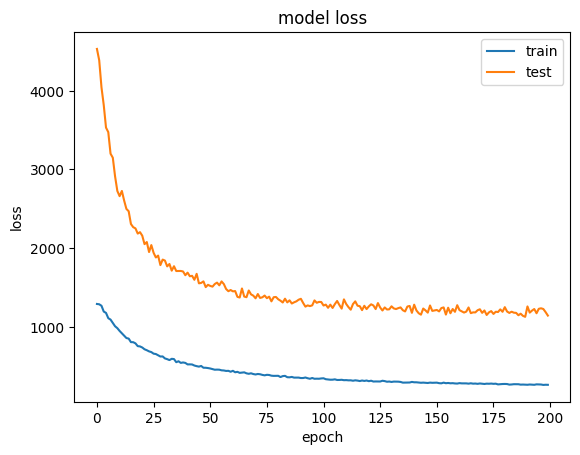

In [11]:
#| include: false

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper right")
plt.show()

In [12]:
#| include: false

dist = prob_model(x_val[:3])
print(dist.mean())
print(dist.rate_parameter())

tf.Tensor([7.674597  6.6554127 7.540233 ], shape=(3,), dtype=float32)
tf.Tensor([7.674597  6.6554127 7.540233 ], shape=(3,), dtype=float32)


Once the model has been trained, we can call it on new user/item pairs to produce a Poisson distribution of posterior predicted observations. We can directly sample user ratings from this distribution with `.sample()`, or call its `.rate_parameter()` method to find the posterior predicted rate. The latter offers a higher resolution to rank items for a given user (it is a continuous variable rather than an integer) and is therefore more practical for recommender systems.

When the model is called, each probabilistic layer returns a single sample from its learned variational distribution. To estimate the posterior predicted Poisson rate of a user/item interaction, one can call the model several times to obtain a sample. In real world applications, drawing a single Poisson rate or only a few of them rather than estimating the posterior mean to score an item might prove more useful as it offers a broader variety of suggestions to users whose tastes are less certain, namely with user embedding distributions of higher variance. It addresses the exploration-exploitation trade-off with a mechanism similar to [Thompson sampling](https://en.wikipedia.org/wiki/Thompson_sampling) (see also this previous [blog post](https://ybarmaz.github.io/blog/posts/2021-02-09-contextual_bandits.html)).

In general, users who have provided less ratings or good ratings across a large spectrum of items will get less defined embeddings, and this approach will give them recommendations that explore the item landscape more broadly than for users with tighter embeddings. These users with better-known tastes will still get random suggestions relatively far from their usual preference, albeit less frequently than the users with less defined embeddings, but this is not something that happens with models based on classical embeddings, which always return the same results.

This mechanism is also interesting when acquiring new users who have not yet provided ratings. We can itialize their embeddings to match the priors, or learned distributions from similar users but with wider variance, and use this untrained model to draw recommendations that are compatible with our prior knowledge. When they start giving ratings, we can train the corresponding user embedding layers to incorporate the new knowledge, while freezing the item embedding layers for stability and increased speed.

With TensorFlow Probability layers, we can thus add a Bayesian flavor to more traditional recommender systems and address issues such as exploration-exploitation trade-offs or cold starts in a more principled way. From another angle, we can express probabilistic models such as matrix factorization models as Keras models and take advantage of the `tf.data.Dataset` API for batch training with potentially large datasets.

In [13]:
#| include: false

def get_posterior_score(x, n_sample=10, model=prob_model, threshold=6):
    posterior_sample = [model(x).mean() for _ in range(n_sample)]
    posterior_sample = tf.stack(posterior_sample, axis=1)
    mean_score = tf.reduce_mean(posterior_sample, axis=1)
    std_score = tf.math.reduce_std(posterior_sample, axis=1)
    
    chances_good = tf.reduce_mean(tf.cast(posterior_sample>threshold, tf.float32), axis=1)
    return mean_score, std_score, chances_good

In [17]:
#| include: false

movie_df = pd.read_csv(movielens_dir / "movies.csv")

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched, [[1]] * len(movies_not_watched), [[1]] * len(movies_not_watched))
)
user_movie_array = tf.convert_to_tensor(user_movie_array, tf.float32)
#ratings = np.mean(np.concatenate([prob_model.predict(user_movie_array) for _ in range(50)], axis=1), axis=1)
ms, ss, cg = get_posterior_score(user_movie_array, 50)
ratings = ms.numpy()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)


Showing recommendations for user: 274
Movies with high ratings from user
--------------------------------
Fight Club (1999) : Action|Crime|Drama|Thriller
Scarface (1983) : Action|Crime|Drama
Kill Bill: Vol. 2 (2004) : Action|Drama|Thriller
Inglourious Basterds (2009) : Action|Drama|War
Inception (2010) : Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX
--------------------------------
Top 10 movie recommendations
--------------------------------
Trigger Effect, The (1996) : Drama|Thriller
Obsession (1976) : Mystery|Thriller
Scaramouche (1952) : Adventure|Romance
Teahouse of the August Moon, The (1956) : Comedy
Samurai Assassin (Samurai) (1965) : Action|Adventure|Drama
Beer League (2006) : Comedy
Daddy Day Camp (2007) : Children|Comedy
Atomic Submarine, The (1959) : Sci-Fi|Thriller
Brass Teapot, The (2012) : Comedy|Fantasy|Thriller
Self-criticism of a Bourgeois Dog (2017) : Comedy


label
0.0    7.225362
1.0    7.362206
2.0    6.780442
3.0    7.200539
4.0    6.907515
5.0    7.583529
6.0    7.668777
7.0    7.994417
8.0    8.216459
9.0    8.589090
Name: score, dtype: float32


<AxesSubplot:xlabel='label', ylabel='score'>

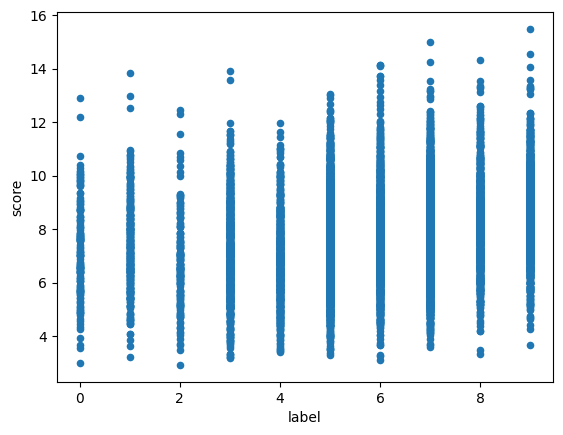

In [15]:
#| include: false

ms, ss, cg = get_posterior_score(x_val, 50)
df_result = pd.DataFrame({'label': y_val, 'score': ms, 'delta': ss, 'cg':cg})
df_result['rel_delta'] = df_result['delta'] / df_result['score']

print(df_result.groupby(['label'])['score'].mean())

df_result.plot.scatter('label', 'score')